## 参考文献汇总
- Reference 1: Kaggle Kernel [Code sharing, 13th place, no external data](https://www.kaggle.com/c/rossmann-store-sales/discussion/17979)
- Reference 2: Kaggle Kernel-[A Journey through Rossmann Stores](https://www.kaggle.com/omarelgabry/rossmann-store-sales/a-journey-through-rossmann-stores)
- Reference 3: Kaggle Kernel-[Predict_sales_with_pandas](https://www.kaggle.com/zygmunt/rossmann-store-sales/predict-sales-with-pandas-py)
- Reference 4:[XGBoost:Notes on Parameter Tuning](http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html)
- Reference 5:[XGBoost Parameters](http://xgboost.readthedocs.io/en/latest/parameter.html)
- Reference 6:[Complete Guide to Parameter Tuning in XGBoost (with codes in Python)](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- Reference 7:[XGBoost Feature Importance](https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2)


## 程序使用说明
1. 运行程序前，从[Kaggle](https://www.kaggle.com/c/rossmann-store-sales/data)官网下载数据store.csv.zip、train.csv.zip和test.csv.zip，将解压后的store.csv、train.csv、test.csv放在与本文档同目录下的data文件夹中
2. "RossmanSales_Part_01_DataPreprocessing.ipynb"会生成后续数据可视化、模型训练所需要的数据
4. "RossmanSales_Part_02_VisualExploration.ipynb"为数据可视化，需使用Part 1生成的数据
5. “RossmanSales_Part_03_BenchmarkModel.ipynb”生成基准模型，需使用Part 1生成的数据
6. “RossmanSales_Part_04_XGBoost_HyperPara_Optimization.ipynb”使用XGBoost方法训练模型，并进行超参数优化；需使用Part 1生成的数据；
7. 文件夹说明：
    - data： 保存store.csv、train.csv、test.csv
    - data_inter_transfer：保存"RossmanSales_Part_01_DataPreprocessing.ipynb"生成的数据
    - output_csv：保存用来提交到Kaggle的结果文件
    - model_saved：保存生成的模型

## 准备工作
### 0.1 调入库函数

In [2]:

#基本计算类
import pandas as pd
import numpy as np
from pandas import Series,DataFrame

#可视化
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display 

#xgboost库函数
import xgboost as xgb


#时间类
import time
import datetime
from isoweek import Week

#文件类
import os

#其他
import itertools
import operator

#基本设定

%matplotlib inline
sns.set_style('whitegrid')

### 0.2 定义评估指标
本项目采用Kaggle比赛的评估指标：RMSPE（误差百分比的均方差），可表示为
$$
RMSPE= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\frac{y_i-\hat{y_i}}{y_i})^2}
$$
其中，任何当天销售额为0的数据在评估时将被忽略； $y_i$ 表示某药店在某天的实际销售额，而$\hat{y_i}$ 表示该药店在对应这一天的预测销售额。

### 0.3 Setting seed

In [3]:
seed_1=42

## 3. 训练基准模型

###  3.0 将处理好的数据从本地硬盘读入

In [4]:
path='data_inter_transfer'
file_train_store_raw_df='train_store_raw_df.pickle'
file_test_store_raw_df='test_store_raw_df.pickle'

train_store_raw_df=pd.read_pickle(os.path.join(path, file_train_store_raw_df))
test_store_raw_df=pd.read_pickle(os.path.join(path, file_test_store_raw_df))

### 3.1 从train_store_raw_df数据集中划分出：训练集和验证集，使用训练集训练模型，使用验证集验证模型的泛化效果
- 用2015-06-22之前的数据作为训练集
- 将2015-06-22之后的数据作为验证集

In [5]:
startValidDate='2015-06-15'
mask_train=train_store_raw_df['Date']<startValidDate
mask_valid=(train_store_raw_df['Date']>=startValidDate) 


benchmark_train_df=train_store_raw_df[mask_train].copy()
benchmark_valid_df=train_store_raw_df[mask_valid].copy()

### 3.2 挑选出最优的特征组合训练基准模型

#### 3.2.1  训练基准模型
- 基准模型采用具有相同特征参数数据子集的中位数；
- 采用的特征包含药店编号、星期几，月份、是否促销等；
- 将特征组合与对应RMSPE存到dict features_RMSPE

#### 3.2.2 对验证集进行测试
- 利用选好的特征，训练出基准模型
- 将model结果以dict形式进行保存，以便于高效计算
- 使用训练好的基准模型对验证集进行测试：applymap方法可以非常高效地求出映射结果

#### 3.2.3 定义评估函数
本项目采用Kaggle比赛的评估指标：RMSPE（误差百分比的均方差），可表示为
$$
RMSPE= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\frac{y_i-\hat{y_i}}{y_i})^2}
$$
其中，任何当天销售额为0的数据在评估时将被忽略； $y_i$ 表示某药店在某天的实际销售额，而$\hat{y_i}$ 表示该药店在对应这一天的预测销售额。

#### 3.2.4 求出基准模型在验证集上的RMSPE

In [6]:
#使用训练好的基准模型对验证集进行测试：applymap方法可以非常高效地求出映射结果
def predict_benchmark_model(df,features,map_dict):
    mask_0=df['Open']==0
    mask_1=df['Open']!=0
    df.loc[mask_0,'Sales_Predicted']=0
    df['tuple_map']=df[features].apply(tuple,axis=1)
    df.loc[mask_1,'Sales_Predicted']=df.loc[mask_1,'tuple_map'].map(map_dict)
    return df

#定义评估函数
def calc_RMSPE(input_df,true_label='Sales',predicted_label='Sales_Predicted'):
    mask=input_df[true_label]>0
    sale=input_df.loc[mask,[true_label,predicted_label]]
    sale['errror']=np.power((sale[true_label]-sale[predicted_label])/sale[true_label],2.0)
    return np.sqrt(np.sum(sale['errror'])/(len(sale)))

#采用的特征包含药店编号、星期几，月份、是否促销、当天是否促销2等；
features_benchmark=(['Store','DayOfWeek','Promo','Month','InPromo2Today'])
#将特征组合与对应RMSPE存到dict features_RMSPE
features_RMSPE={}
#将特征组合与对应dict存到benchmark_model_dict，不用再次计算
benchmark_model_dict={}

#提取出所有可能的特征组合放入subset
for L in range(2, len(features_benchmark)+1):
    for subset in itertools.combinations(features_benchmark, L):
        valid_df=benchmark_valid_df.copy()
        
        features=list(subset)
        features_sales=features+['Sales']
        
        #利用选好的特征，训练出基准模型
        benchmark_model=benchmark_train_df[benchmark_train_df['Open']==1][features_sales].groupby(features).median()
        #将model结果以dict形式进行保存，以便于高效计算
        benchmark_model_dict[subset]=benchmark_model['Sales'].to_dict()
        
        valid_df= predict_benchmark_model(valid_df,features,benchmark_model_dict[subset])   
        RMSPE_valid_benchmark=calc_RMSPE(valid_df)
        features_RMSPE[subset]=RMSPE_valid_benchmark

#### 3.2.5 打印在验证集上features_RMSPE中数值较小的三个

In [7]:
#打印features_RMSPE中数值较小的三个
sorted_RMSPE = sorted(features_RMSPE.items(), key=operator.itemgetter(1))
print("-----------RMSPE较小的三个特征组合与在对应验证集的RMSPE-------------")
for ii in range(3):
    print sorted_RMSPE[ii][0],':%.5f'%(sorted_RMSPE[ii][1])
print ('--------------------------------------------------------------------')
benchmark_features=list(sorted_RMSPE[0][0])
print 'Featuress for benchmark model:',benchmark_features

-----------RMSPE较小的三个特征组合与在对应验证集的RMSPE-------------
('Store', 'DayOfWeek', 'Promo', 'InPromo2Today') :0.14091
('Store', 'DayOfWeek', 'Promo') :0.14123
('Store', 'DayOfWeek', 'Promo', 'Month', 'InPromo2Today') :0.14657
--------------------------------------------------------------------
Featuress for benchmark model: ['Store', 'DayOfWeek', 'Promo', 'InPromo2Today']


### 3.3 挑出使得验证集结果最好的特征组合作为基准模型的特征，并求出在验证集和测试集的结果

In [8]:
benchmark_train_df= predict_benchmark_model(benchmark_train_df,benchmark_features,benchmark_model_dict[tuple(benchmark_features)])   
RMSPE_train_benchmark=calc_RMSPE(benchmark_train_df)
print('基准模型在训练集上的RMSPE:{:.6f}'.format(RMSPE_train_benchmark))

benchmark_valid_df= predict_benchmark_model(benchmark_valid_df,benchmark_features,benchmark_model_dict[tuple(benchmark_features)])   
RMSPE_valid_benchmark=calc_RMSPE(benchmark_valid_df)
print('基准模型在验证集上的RMSPE:{:.6f}'.format(RMSPE_valid_benchmark))


基准模型在训练集上的RMSPE:0.225588
基准模型在验证集上的RMSPE:0.140907


### 3.4 使用基准模型对测试集进行预测，并输出结果

In [8]:
test_store_raw_df= predict_benchmark_model(test_store_raw_df,benchmark_features,benchmark_model_dict[tuple(benchmark_features)])   
path='output_csv'
file_name='benchmark_using_'+'_'.join(benchmark_features)+'.csv'

pd.DataFrame({'Id':test_store_raw_df['Id'],'Sales':test_store_raw_df['Sales_Predicted']}).to_csv(os.path.join(path,file_name),index=False)

提交到Kaggle官网，可以得到 Public Score=0.14210，Private Score=0.14976

### 3.5 使用基准模型对验证集进行预测，并分析结果

mean=756.3
median=534.0
max=32626.0
min=0.0
sum=34669773.0
sum_percent=10.58%
median_percent=8.14%


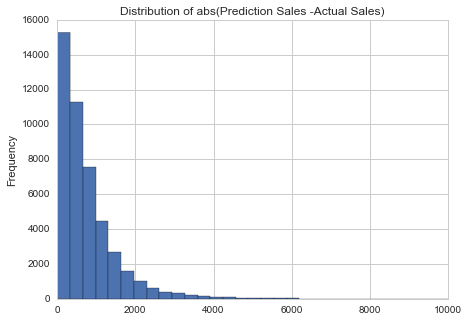

In [13]:
mask=benchmark_valid_df['Open']==1
y_diff=np.abs((benchmark_valid_df['Sales']-benchmark_valid_df['Sales_Predicted'])[mask])
print 'mean={:.1f}'.format(y_diff.mean())
print 'median={:.1f}'.format(y_diff.median())
print 'max={:.1f}'.format(y_diff.max())
print 'min={:.1f}'.format(y_diff.min())
print 'sum={:.1f}'.format(y_diff.sum())
print 'sum_percent={:.2f}%'.format(100.0*y_diff.sum()/abs(np.sum(benchmark_valid_df[mask]['Sales'])))
print 'median_percent={:.2f}%'.format(100.0*y_diff.median()/abs(np.median(benchmark_valid_df[mask]['Sales'])))


fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
#Sales
_ =y_diff.plot(kind='hist',bins=100,xlim=(0,10000),ax=axis1,title='Distribution of abs(Prediction Sales -Actual Sales)')